In [165]:
import os 
import torch
import joblib
import numpy as np
import os.path as osp
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.ensemble import RandomForestRegressor
import heapq
import matplotlib.pyplot as plt

## Utils


In [166]:
torch.set_default_dtype(torch.double)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = {
    #'dataset': 'IPIN2020_Track3_5F', #['NTU_CSIE_5F', 'DSI', 'IPIN2016_Tutorial', 'IPIN2020_Track3_2F', 'IPIN2020_Track3_3F', 'IPIN2020_Track3_5F']
    'dataset':'NTUH_2F',
    'method': 'DSAR',#['WKNN', 'RandomForest', 'WiDeep', 'DSAR']
}

def check_format():
    assert config['method'] in ['WKNN', 'RandomForest', 'WiDeep', 'DSAR'], \
        'config method should be [WKNN, RandomForest, WiDeep, DSAR]'
    assert config['dataset'] in ['NTUH_2F','NTU_CSIE_5F', 'DSI', 'IPIN2016_Tutorial', 'IPIN2020_Track3_2F', 'IPIN2020_Track3_3F', 'IPIN2020_Track3_5F'], \
        'config dataset should be [NTU_CSIE_5F, DSI, IPIN2016_Tutorial, IPIN2020_Track3_2F, IPIN2020_Track3_3F, IPIN2020_Track3_5F]'



def load(dataset):
    dir_path = osp.join(os.getcwd(), 'Dataset', dataset)

    training_wifi_pos = np.load(osp.join(dir_path, 'training_wifi_pos.npy'))
    testing_wifi_pos = np.load(osp.join(dir_path, 'testing_wifi_pos.npy'))

    return training_wifi_pos, testing_wifi_pos



def normalize_rssi(rssi):
    return (rssi + 100) / 100



def normalize_pos(pos, boundary):
    max_x, min_x, max_y, min_y = boundary
    norm_pos = np.zeros_like(pos)
    norm_pos[:,0] = (pos[:,0] - min_x) / (max_x - min_x)
    norm_pos[:,1] = (pos[:,1] - min_y) / (max_y - min_y)
    return norm_pos



def restore_pos(norm_pos, boundary):
    max_x, min_x, max_y, min_y = boundary
    pos = np.zeros_like(norm_pos)
    pos[:,0] = norm_pos[:,0] * (max_x - min_x) + min_x
    pos[:,1] = norm_pos[:,1] * (max_y - min_y) + min_y
    return pos



def get_rps(training_wifi_pos):

    rps = {}
    for i in range(training_wifi_pos.shape[0]):
        pos = tuple(training_wifi_pos[i,-2:])
        if pos not in rps:
            rps[pos] = training_wifi_pos[None,i,:-2]
        else:
            rps[pos] = np.r_[rps[pos], training_wifi_pos[None,i,:-2]]
    return rps
        


def add_noise(rssi):
    noisy_rssi = rssi + torch.normal(0, 0.1, rssi.shape)
    noisy_rssi = torch.clip(noisy_rssi, 0, 1)
    mask = torch.rand(rssi.shape) < 0.1
    noisy_rssi[mask] = 0
    return noisy_rssi
    


def get_boundary(training_pos, testing_pos):
    max_x = max(training_pos[:,0].max(), testing_pos[:,0].max())
    min_x = min(training_pos[:,0].min(), testing_pos[:,0].min())
    max_y = max(training_pos[:,1].max(), testing_pos[:,1].max())
    min_y = min(training_pos[:,1].min(), testing_pos[:,1].min())
    
    return (max_x, min_x, max_y, min_y)



def RBF(origin, reconstruction, gamma=16, axis=None):
    return np.e**(-gamma * np.linalg.norm(origin - reconstruction, axis=axis)**2)



def plot_wifi_pos(dataset, method, training_pos, testing_pos, pred_pos, pred_err):

    dir_path = osp.join(os.getcwd(), 'Result', dataset, method)

    fig, (axs0, axs1, axs2) = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)

    axs0.plot(training_pos[:,0], training_pos[:,1], 'ob')
    axs0.set_title('Training Points')
    axs0.grid()

    axs1.plot(testing_pos[:,0], testing_pos[:,1], 'og')
    axs1.set_title('Testing Points')
    axs1.grid()

    axs2.plot(pred_pos[:,0], pred_pos[:,1], 'or')
    axs2.set_title('Prediction Points')
    axs2.grid()

    fig.tight_layout()
    plt.savefig(osp.join(dir_path, dataset), bbox_inches='tight')
    np.save(osp.join(dir_path, 'loc_err.npy'), pred_err)
    np.save(osp.join(dir_path, 'pred_pos.npy'), pred_pos)
    
    
def plot_loss(r_losses, reg_losses, v_losses):
    x = [i for i in range(len(r_losses))]
    
    plt.plot(x, r_losses , label = "rec loss")
    plt.plot(x, reg_losses, label = "reg loss")
    plt.plot(x, v_losses, label = "val loss")
    plt.legend()
    plt.show()


def DSAR_testing(query_wifi_pos, dataset, boundary):

    dir_path = osp.join(os.getcwd(), 'Result', dataset, 'DSAR')
    inputs = normalize_rssi(query_wifi_pos[:,:-2])
    labels = query_wifi_pos[:,-2:]

    path = osp.join(dir_path, 'dsar.pth') 
    network = torch.load(path).to(device) # if u don't have gpu, add map_location='cpu' in load's parameter
    network.eval()

    with torch.no_grad():
        inputs = torch.from_numpy(inputs).to(device)
        rssi_reconst, pos = network(inputs)
        rssi_reconst = rssi_reconst.cpu().numpy()
        pred_pos = restore_pos(pos.cpu().numpy(), boundary)
        loc_err = np.linalg.norm(pred_pos - labels, axis=1)

    return pred_pos, loc_err, rssi_reconst



## Model

In [167]:
import torch.nn as nn

class DenoisingAutoEncoder(nn.Module):
    def __init__(self, input_size):
        super(DenoisingAutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.Sigmoid(),
            nn.Linear(512, 1024),
            nn.Sigmoid(),
            nn.Linear(1024, 2048),
            nn.Sigmoid(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.Sigmoid(),
            nn.Linear(1024, 512),
            nn.Sigmoid(),
            nn.Linear(512, input_size),
            nn.Sigmoid(),
        )

        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data = nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('sigmoid')) 

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class AutoRegression(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AutoRegression, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.Sigmoid(),
            nn.Linear(256, 128),
            nn.Sigmoid(),
            nn.Linear(128, hidden_size),
            nn.Sigmoid(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.Sigmoid(),
            nn.Linear(128, 256),
            nn.Sigmoid(),
            nn.Linear(256, input_size),
            nn.Sigmoid()
        )

        self.regression = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
        )


        for m in self.encoder.modules():
            if isinstance(m, nn.Linear):
                m.weight.data = nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('sigmoid'))
        for m in self.decoder.modules():
            if isinstance(m, nn.Linear):
                m.weight.data = nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('sigmoid'))

        for m in self.regression.modules():
            if isinstance(m, nn.Linear):
                m.weight.data = nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu')) 

    def forward(self, x):
        x = self.encoder(x)
        o1 = self.decoder(x)
        o2 = self.regression(x)
        return (o1, o2)





## Training 

In [168]:

class RadioMap(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = torch.from_numpy(inputs)
        self.labels = torch.from_numpy(labels)
        
    def __getitem__(self, index):
        return (self.inputs[index], self.labels[index])
        
    def __len__(self):
        return len(self.labels)
def DSAR_training(dataset, training_wifi_pos, boundary):
    dir_path = osp.join(os.getcwd(), 'Result', dataset, 'DSAR')
    rps = get_rps(training_wifi_pos)

    inputs = normalize_rssi(training_wifi_pos[:,:-2])
    labels = normalize_pos(training_wifi_pos[:,-2:], boundary)
    radio_map = RadioMap(inputs, labels)
    loader = DataLoader(dataset=radio_map, shuffle=True, batch_size=16)
    
    r_losses = []
    reg_losses = []
    V_losses = []

    val_inputs = []
    val_labels = []
    for rp_pos in rps:
        val_inputs.append(np.average(rps[rp_pos], axis=0))
        val_labels.append(np.array(rp_pos, dtype=np.float64))

    val_inputs = normalize_rssi(np.array(val_inputs, dtype=np.float64))
    val_labels = normalize_pos(np.array(val_labels, dtype=np.float64), boundary)
    val_radio_map = RadioMap(val_inputs, val_labels)
    val_loader = DataLoader(dataset=val_radio_map, shuffle=True, batch_size=8)

    epochs = 5000
    input_size = training_wifi_pos.shape[1] - 2
    hidden_size = len(rps)

    network = AutoRegression(input_size, hidden_size).to(device)        
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    criterion = torch.nn.MSELoss()

    best_val_loss = np.inf
    losses = np.zeros((epochs,3), dtype=np.float64)

    network.train()
    for epoch in range(epochs):
        reconst_losses = 0.0
        regression_losses = 0.0

        for inputs, labels in loader:

            noisy_inputs = add_noise(inputs).to(device)
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            reconst_rssi, pos = network(noisy_inputs)

            reconst_loss = criterion(inputs, reconst_rssi)
            regression_loss = criterion(labels, pos)

            loss = reconst_loss + regression_loss
            loss.backward()
            optimizer.step()

            reconst_losses += reconst_loss.item()
            regression_losses += regression_loss.item()
        
        losses[epoch,0] = reconst_losses
        losses[epoch,1] = regression_losses

        network.eval()
        val_losses = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                reconst, pos = network(inputs)
                val_losses += (labels - pos).pow(2).sum()
        
        losses[epoch,2] = val_losses

        if val_losses < best_val_loss:
            best_val_loss = val_losses
            torch.save(network, osp.join(dir_path, 'dsar.pth'))
        
        r_losses.append(reconst_losses)
        reg_losses.append(regression_losses)
        V_losses.append(val_losses.item())
       
        print(f'Epoch {epoch}, reconstruction losses: {reconst_losses}, regression losses: {regression_losses}, validation losses: {val_losses}')

    np.save(osp.join(dir_path, 'losses.npy'), losses)
    
    plot_loss(r_losses, reg_losses, V_losses)




Epoch 0, reconstruction losses: 0.9477538807687018, regression losses: 1.1508722406969627, validation losses: 6.347909588551528
Epoch 1, reconstruction losses: 0.2507860024340247, regression losses: 0.7258469797800299, validation losses: 5.6589360762581435
Epoch 2, reconstruction losses: 0.08384497729130905, regression losses: 0.6414799434337606, validation losses: 5.991634855186013
Epoch 3, reconstruction losses: 0.05997190392673346, regression losses: 0.789053103002384, validation losses: 5.932682746216062
Epoch 4, reconstruction losses: 0.05839559410630722, regression losses: 0.6576198410733657, validation losses: 5.754509096321535
Epoch 5, reconstruction losses: 0.05727001716192889, regression losses: 0.6621727961997653, validation losses: 6.2473921573235325
Epoch 6, reconstruction losses: 0.05696817215418586, regression losses: 0.8133088935288684, validation losses: 5.615992575894057
Epoch 7, reconstruction losses: 0.0553318606057574, regression losses: 0.6518153119684573, validat

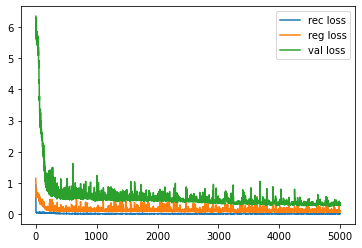

In [169]:
check_format()

dataset, method = config.values()

training_wifi_pos, testing_wifi_pos = load(dataset)

boundary = get_boundary(training_wifi_pos[:, -2:], testing_wifi_pos[:, -2:])

DSAR_training(dataset, training_wifi_pos, boundary)



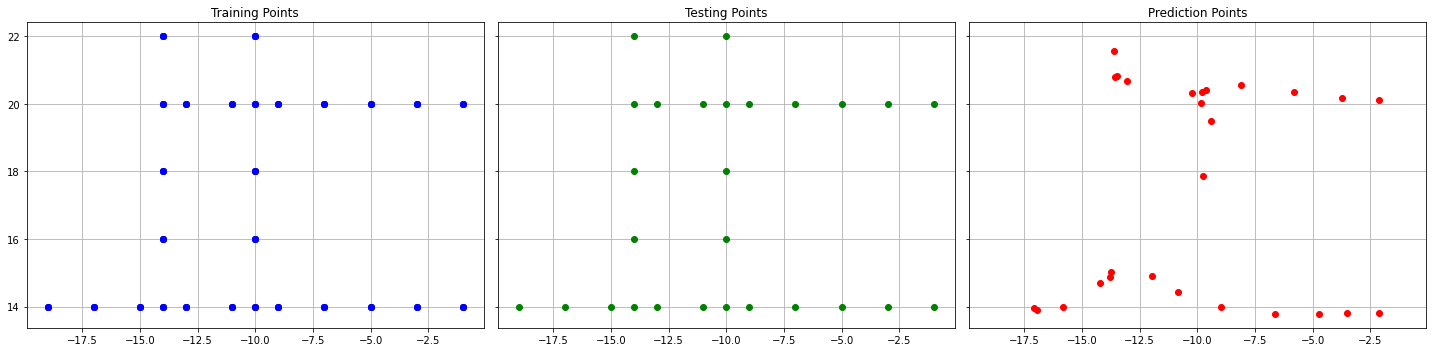

In [170]:
testing_pos, testing_err, rssi_reconst = DSAR_testing(testing_wifi_pos, dataset, boundary)
avg_test_err= sum(testing_err) / len(testing_err)
plot_wifi_pos(dataset, method, training_wifi_pos[:,-2:], testing_wifi_pos[:,-2:], testing_pos, testing_err)


In [171]:
#listing the difference of original label and predicted label
import cmath
testing_labels = testing_wifi_pos[:, -2:]
for i, label in enumerate(testing_labels):
    err = (label - testing_pos[i])
    err = cmath.sqrt(err[0]**2 + err[-1]**2)
    print(f"original label = {label} -> predicted label = {testing_pos[i]}, err = {err}")
print(f"testing avg error = {avg_test_err}")


original label = [-1. 14.] -> predicted label = [-2.09986868 13.81645428], err = (1.1150785348964487+0j)
original label = [-1. 20.] -> predicted label = [-2.09980446 20.11606396], err = (1.1059117016835738+0j)
original label = [-10.  14.] -> predicted label = [-10.83162254  14.44535265], err = (0.9433636817969159+0j)
original label = [-10.  16.] -> predicted label = [-9.74237739 17.85402425], err = (1.8718374168330927+0j)
original label = [-10.  18.] -> predicted label = [-9.42107352 19.50644187], err = (1.6138534539936769+0j)
original label = [-10.  20.] -> predicted label = [-9.85203365 20.03528288], err = (0.15211483479636043+0j)
original label = [-10.  22.] -> predicted label = [-9.79271764 20.36111158], err = (1.651944682488057+0j)
original label = [-11.  14.] -> predicted label = [-11.97386488  14.90720921], err = (1.3309550530403071+0j)
original label = [-11.  20.] -> predicted label = [-10.23157095  20.32530128], err = (0.8344483980686628+0j)
original label = [-13.  14.] -> pre